In [10]:
# Python lib
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

import os
import sys

import torchvision.transforms as T

In [2]:
sub = pd.read_csv('data/kaggle/sample_submission.csv')
sub.head()

,ImageId,PredictionString
0,b5d912e06f74e948,/m/05s2s 0.9 0.46 0.08 0.93 0.5 /m/0c9ph5 0.5 ...
1,be137cf6bb0b62d5,/m/05s2s 0.9 0.46 0.08 0.93 0.5 /m/0c9ph5 0.5 ...
2,8d65ca08cb5ce8e8,/m/05s2s 0.9 0.46 0.08 0.93 0.5 /m/0c9ph5 0.5 ...
3,4d3ad1e52ad8c065,/m/05s2s 0.9 0.46 0.08 0.93 0.5 /m/0c9ph5 0.5 ...
4,9b94408691c7d7bf,/m/05s2s 0.9 0.46 0.08 0.93 0.5 /m/0c9ph5 0.5 ...


In [3]:
test_data_dir = 'data/kaggle/test_data'
test_filename = os.listdir(test_data_dir)
test_filename[:5]

['0c321f4e89abab08.jpg',
 'a3e937181e4495d8.jpg',
 '732990bbb9466fbb.jpg',
 'cb9dd9d419194de9.jpg',
 '99326016a88f03aa.jpg']

In [4]:
def show_image_by_index(i):
    sample_image = plt.imread(f'{test_data_dir}/{test_filename[i]}')
    plt.imshow(sample_image)

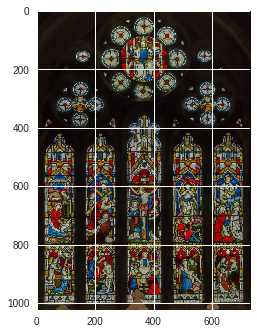

In [5]:
def show_image_by_index(i):
    sample_image = plt.imread(f'{test_data_dir}/{test_filename[i]}')
    plt.imshow(sample_image)
show_image_by_index(7)

In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/daniel/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 167502836/167502836 [00:16<00:00, 10266992.24it/s]


In [7]:
csv_dir = "/hdd/open-images/csvs"
train_csv = pd.read_csv(f"{csv_dir}/train-annotations-bbox.csv")
train_csv = pd.read_csv(f"{csv_dir}/train-annotations-bbox.csv")
label_counts = train_csv["LabelName"].value_counts()
num_greater_than_50 = len(label_counts[label_counts >= 50])
print("Number of classes with at least 50 examples: ", num_greater_than_50)
num_classes = num_greater_than_50

Number of classes with at least 50 examples:  574


In [8]:
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [11]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [13]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

class PennFudanDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)
    
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe: pd.DataFrame, mode: str) -> None:
        print(f'creating data loader - {mode}')
        assert mode in ['train', 'val', 'test']

        self.df = dataframe
        self.mode = mode

        if self.mode == "test":
            transforms_list = [
                transforms.CenterCrop(ORIGINAL_IMAGE_SIZE),
                transforms.Resize(IMAGE_SIZE)
            ]
        elif self.mode == "train":
            transforms_list = [
                # transforms.Resize(IMAGE_SIZE)
                transforms.Resize(ORIGINAL_IMAGE_SIZE)
            ]
        else:
            transforms_list = [
                transforms.Resize(IMAGE_SIZE)
                # transforms.Resize(ORIGINAL_IMAGE_SIZE)
            ]

        if self.mode == 'train':
            transforms_list.extend([
                transforms.RandomHorizontalFlip(),
                transforms.RandomResizedCrop(IMAGE_SIZE),
                transforms.RandomChoice([
                    transforms.RandomChoice([
                        transforms.RandomResizedCrop(IMAGE_SIZE),
                        transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
                        transforms.RandomAffine(degrees=15, translate=(0.2, 0.2),
                                                scale=(0.8, 1.2), shear=15,
                                                resample=Image.BILINEAR)
                    ]),
                    transforms.RandomChoice([
                        transforms.Grayscale(num_output_channels=3),
                        transforms.RandomRotation(degrees=90),
                        transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
                        transforms.RandomAffine(degrees=15, translate=(0.2, 0.2),
                                                scale=(0.8, 1.2), shear=15,
                                                resample=Image.BILINEAR)
                    ])
                ])
            ])


        transforms_list.extend([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225]),
        ])
        self.transforms = transforms.Compose(transforms_list)

    def __getitem__(self, index: int) -> Any:
        ''' Returns: tuple (sample, target) '''
        filename = self.df.id.values[index]

        part = 1 if self.mode == 'test' or filename[0] in '01234567' else 2
        directory = 'test' if self.mode == 'test' else 'train_' + filename[0]
        # sample = Image.open(f'../input/google-landmarks-2019-64x64-part{part}/{directory}/{self.mode}_64/{filename}.jpg')
        if self.mode == "train":
            sample = Image.open(f'/home/daniel/kaggle/landmarks/data_kernel/{self.mode}/{self.mode}_{ORIGINAL_IMAGE_SIZE}/{filename}.jpg')
        elif self.mode == "val":
            sample = Image.open(f'/home/daniel/kaggle/landmarks/data_kernel/train/train_{ORIGINAL_IMAGE_SIZE}/{filename}.jpg')
        else:
            # sample = Image.open(f'/hdd/kaggle/landmarks/test_images/{filename}.jpg')
            sample = Image.open(f'/hdd/kaggle/landmarks/test_images2/{filename}.jpg')
        assert sample.mode == 'RGB'

        image = self.transforms(sample)

        if self.mode == 'test':
            return image
        else:
            return image, self.df.landmark_id.values[index]

    def __len__(self) -> int:
        return self.df.shape[0]

In [ ]:
def load_data(checkpoint: any = None) -> 'Tuple[DataLoader[np.ndarray], DataLoader[np.ndarray], LabelEncoder, int]':
    torch.multiprocessing.set_sharing_strategy('file_system')
    cudnn.benchmark = True
    label_column_name = "LabelName"
    train_data_dir = "data/unzipped/train"
    id_column = "ImageID"

    # only use classes which have at least MIN_SAMPLES_PER_CLASS samples
    print('loading data...')
    df = pd.read_csv(csv_dir + f'{TRAIN_CSV}.csv')
#     df.drop(columns='url', inplace=True)

    counts = df[label_column_name].value_counts()
    selected_classes = counts[counts >= MIN_SAMPLES_PER_CLASS].index
    num_classes = selected_classes.shape[0]
    print('classes with at least N samples:', num_classes)

    train_df = df.loc[df[label_column_name].isin(selected_classes)].copy()

    print('train_df', train_df.shape)
    train_exists = lambda img: os.path.exists(f'{train_data_dir}/{img}.jpg')
    train_df = train_df.loc[train_df[id_column].apply(train_exists)].copy()
    print('train_df after filtering', train_df.shape)


    if checkpoint != None:
        print("Loading label encoder from checkpoint...")
        label_encoder = checkpoint["label_encoder"]
    else:
        label_encoder = LabelEncoder()
        label_encoder.fit(train_df[label_column_name].values)

    y = train_df.pop(label_column_name)
    x = train_df
    # train_x, val_x, train_y, val_y = train_test_split(x, y, test_size=0.01, random_state=42, stratify=y)
    train_x, val_x, train_y, val_y = train_test_split(x, y, test_size=0.05, random_state=42, stratify=y)
    train_x[label_column_name] = train_y
    val_x[label_column_name] = val_y

    train_df = train_x
    val_df = val_x

    print(f"Train length: {len(train_df)} Val length: {len(val_df)}")

    test_df = pd.read_csv(csv_dir + 'sample_submission.csv', dtype=str)
    # test_df.drop(columns='url', inplace=True)
    print('test_df', test_df.shape)

    # filter non-existing test images
    test_data_dir = "data/kaggle/test_data"
    exists = lambda img: os.path.exists(f'{test_data_dir}/{img}.jpg')

    test_df = test_df.loc[test_df[id_column].apply(exists)].copy()
    print('test_df after filtering', test_df.shape)
    assert test_df.shape[0] > 112000
    # assert test_df.shape[0] > 117703
    if PREDICT_ONLY:
        num_classes = len(label_encoder.classes_)
    print('found classes', len(label_encoder.classes_))
    assert len(label_encoder.classes_) == num_classes

    train_df.landmark_id = label_encoder.transform(train_df.landmark_id)
    val_df.landmark_id = label_encoder.transform(val_df.landmark_id)

    train_dataset = ImageDataset(train_df, mode='train')
    test_dataset = ImageDataset(test_df, mode='test')
    val_dataset = ImageDataset(val_df, mode='val')

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=NUM_WORKERS, drop_last=False)

    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=NUM_WORKERS, drop_last=False)

    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=False, num_workers=NUM_WORKERS, drop_last=False)

    return train_loader, val_loader, test_loader, label_encoder, num_classes

In [ ]:
from engine import train_one_epoch, evaluate
import utils


def main():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and person
    num_classes = num_greater_than_50
    # use our dataset and defined transformations
    dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
    dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    model = get_model_instance_segmentation(num_classes)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 10

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

    print("That's it!")